# Rift Inversion Results Figures
This notebook uses the GDTchron results from `process_riftinversion.ipynb` to create a figure and video showing the results. Note that it relies on that previous notebook having access to large source files, and so it is not reproducible without a local copy of the model results

In [1]:
import os
import shutil
import warnings

import cmcrameri.cm as cmc
import cv2
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
from IPython.display import Video
from tqdm import tqdm

import gdtchron as gdt

plt.rcParams['pdf.fonttype'] = 42

This cell sets an environment variable that is necessary for transparency to render correctly when plotting the strain over the composition from the model

In [2]:
os.environ['GALLIUM_DRIVER'] = 'softpipe'

This cell gathers the paths to the original model files for plotting composition, strain rate, and temperature

In [3]:
# Get full output files from local source
sol_path = (
    'solution'
)
files = [
    os.path.join(sol_path, file) for file in os.listdir(sol_path) 
    if file.endswith('.pvtu')
]
files.sort()

The cell below sets up parameters for the figure.

In [4]:
directory_tchron = 'meshes_tchron'
time1 = 20  # Ma
time2 = 0  # Ma

model_step = 0.1

step1 = int((36 - time1) / model_step)
step2 = int((36 - time2) / model_step)

file1 = files[step1]
file2 = files[step2]

file1_tchron = os.path.join(directory_tchron, 'meshes_tchron_160.vtu')
file2_tchron = os.path.join(directory_tchron, 'meshes_tchron_360.vtu')

colors = ['#66CCEE', '#BBBBBB', '#EE6677', '#228833']
cmap = mcolors.ListedColormap(colors)

opaque_cm = cmc.lapaz_r
cm_strain = 'inferno_r'
cat_cmap = cmc.batlowS

opacity_strain = [0, 0.8, 0.8, 0.8, 0.8]
lim_strain = [0, 5]

lim_tchron = [0, 36]  # Ma

bounds = [250, 750, -20, 150]  # km, X position and depth

The cell below makes the figure, which includes comparison of the structure of the model with the predicted thermochronometric ages

2025-11-19 21:33:51.498 (   2.405s) [    78A71EA6C740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


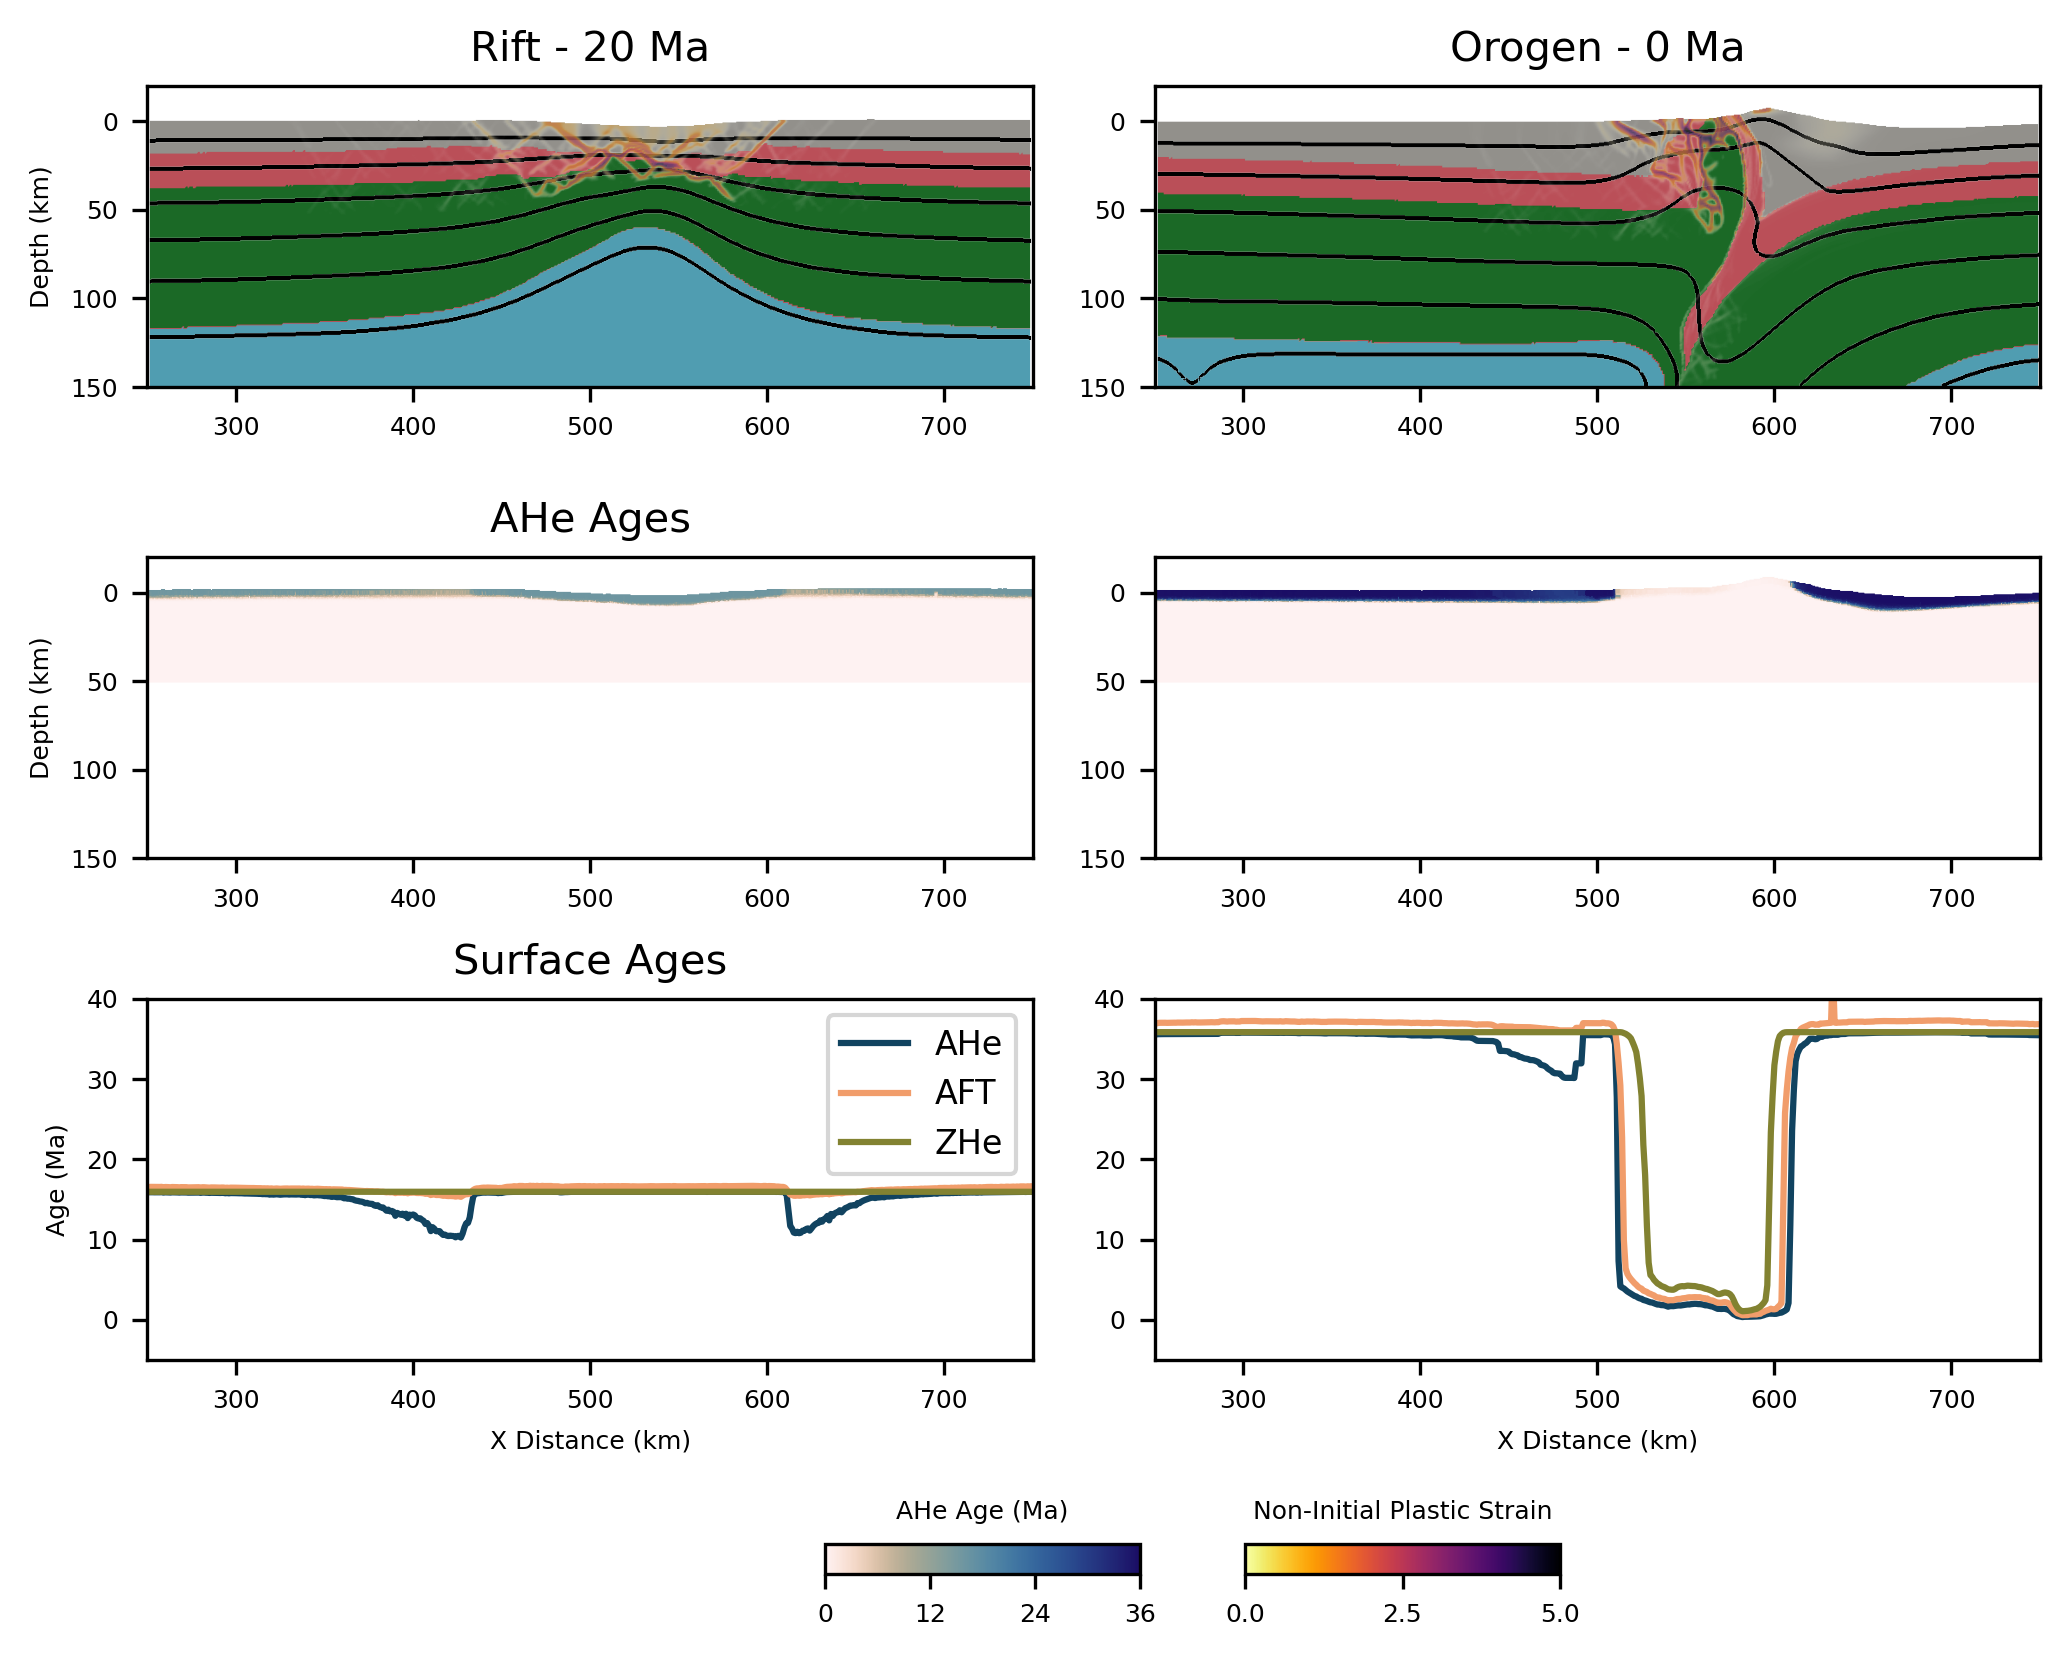

In [ ]:
fig, axs = plt.subplots(3, 2, dpi=300, figsize=(7, 5))

axs = axs.flatten()

axs[0].set_title('Rift - 20 Ma', fontsize=10)
axs[1].set_title('Orogen - 0 Ma', fontsize=10)

axs[2].set_title('AHe Ages', loc='center', fontsize=10)

mesh1 = pv.read(file1)
mesh1.points /= 1e3  # Convert m to km
mesh1['T'] -= 273.15  # Convert temp to °C
mesh1.points[:, 1] = -(mesh1.points[:, 1] - 600)  # Convert Y position to depth

mesh2 = pv.read(file2)
mesh2.points /= 1e3  # Convert m to km
mesh2['T'] -= 273.15  # Convert temp to °C
mesh2.points[:, 1] = -(mesh2.points[:, 1] - 600)  # Convert Y position to depth

mesh1_tchron = pv.read(file1_tchron)
mesh1_tchron.points /= 1e3  # Convert m to km
# Convert Y position to depth
mesh1_tchron.points[:, 1] = -(mesh1_tchron.points[:, 1] - 600)  

mesh2_tchron = pv.read(file2_tchron)
mesh2_tchron.points /= 1e3  # Convert m to km
# Convert Y position to depth
mesh2_tchron.points[:, 1] = -(mesh2_tchron.points[:, 1] - 600)  

mesh1 = gdt.add_comp_field(mesh1)
mesh2 = gdt.add_comp_field(mesh2)

mesh1_cntrs = mesh1.contour(isosurfaces=np.arange(200, 1600, 200), scalars='T')
mesh2_cntrs = mesh2.contour(isosurfaces=np.arange(200, 1600, 200), scalars='T')

gdt.plot_vtk_2d(mesh1, 'comp_field', bounds=bounds, ax=axs[0],
           cmap=cmap)

gdt.plot_vtk_2d(mesh2, 'comp_field', bounds=bounds, ax=axs[1],
            cmap=cmap)

gdt.plot_vtk_2d(mesh1_cntrs, None, bounds=bounds, ax=axs[0],
          color='black', line_width=5, colorbar=True)

gdt.plot_vtk_2d(mesh2_cntrs, None, bounds=bounds, ax=axs[1],
            color='black', line_width=5, colorbar=True)

gdt.plot_vtk_2d(mesh1, 'noninitial_plastic_strain', bounds=bounds, ax=axs[0],
          cmap=cm_strain, opacity=opacity_strain, clim=lim_strain)

gdt.plot_vtk_2d(mesh2, 'noninitial_plastic_strain', bounds=bounds, ax=axs[1],
          cmap=cm_strain, opacity=opacity_strain, clim=lim_strain)

gdt.plot_vtk_2d(mesh1_tchron, 'AHe', bounds=bounds, ax=axs[2],
            cmap=opaque_cm, colorbar=False, clim=lim_tchron)

gdt.plot_vtk_2d(mesh2_tchron, 'AHe', bounds=bounds, ax=axs[3],
            cmap=opaque_cm, colorbar=False, clim=lim_tchron)

x1 = np.round(mesh1_tchron.points[:, 0], 0)
x2 = np.round(mesh2_tchron.points[:, 0], 0)
He1 = mesh1_tchron['AHe']
He2 = mesh2_tchron['AHe']

AFT1 = mesh1_tchron['AFT']
AFT2 = mesh2_tchron['AFT']

ZHe1 = mesh1_tchron['ZHe']
ZHe2 = mesh2_tchron['ZHe']

df1 = pd.DataFrame({'x': x1, 'AHe': He1, 'AFT': AFT1, 'ZHe': ZHe1})
df1_max = df1.groupby('x').agg({'x': 'first', 'AHe': 'max', 'AFT': 'max', 'ZHe': 'max'})
df2 = pd.DataFrame({'x': x2, 'AHe': He2, 'AFT': AFT2, 'ZHe': ZHe2})
df2_max = df2.groupby('x').agg({'x': 'first', 'AHe': 'max', 'AFT': 'max', 'ZHe': 'max'})

axs[0].set_ylabel('Depth (km)', fontsize=6)
axs[2].set_ylabel('Depth (km)', fontsize=6)

axs[4].plot(df1_max['x'], df1_max['AHe'], c=cat_cmap.colors[6], label='AHe')
axs[4].plot(df1_max['x'], df1_max['AFT'], c=cat_cmap.colors[4], label='AFT')
axs[4].plot(df1_max['x'], df1_max['ZHe'], c=cat_cmap.colors[2], label='ZHe')

axs[4].legend(fontsize=8)

axs[5].plot(df2_max['x'], df2_max['AHe'], c=cat_cmap.colors[6])
axs[5].plot(df2_max['x'], df2_max['AFT'], c=cat_cmap.colors[4])
axs[5].plot(df2_max['x'], df2_max['ZHe'], c=cat_cmap.colors[2])

axs[4].set_xlim(250, 750)
axs[5].set_xlim(250, 750)
axs[4].set_ylim(40, -5)
axs[5].set_ylim(40, -5)
axs[4].set_title('Surface Ages', fontsize=10)
axs[4].set_ylabel('Age (Ma)', fontsize=6)
axs[4].set_xlabel('X Distance (km)', fontsize=6)
axs[5].set_xlabel('X Distance (km)', fontsize=6)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.invert_yaxis()

plt.tight_layout()

cax_ahe = fig.add_axes([0.4, -0.05, 0.15, 0.02])
norm = mcolors.Normalize(vmin=lim_tchron[0], vmax=lim_tchron[1])
sm_ahe = cm.ScalarMappable(cmap=opaque_cm, norm=norm)
cax_ahe.tick_params(labelsize=6)
plt.colorbar(sm_ahe, cax=cax_ahe, orientation='horizontal')
cax_ahe.set_title('AHe Age (Ma)', fontsize=6)
cax_ahe.set_xticks([0, 12, 24, 36])

cax_strain = fig.add_axes([0.6, -0.05, 0.15, 0.02])
norm = mcolors.Normalize(vmin=lim_strain[0], vmax=lim_strain[1])
sm_strain = cm.ScalarMappable(cmap=cm_strain, norm=norm)
cax_strain.tick_params(labelsize=6)
plt.colorbar(sm_strain, cax=cax_strain, orientation='horizontal')
cax_strain.set_title('Non-Initial Plastic Strain', fontsize=6)
cax_strain.set_xticks([0, 2.5, 5])

fig.savefig('riftvsinv.pdf', bbox_inches='tight')

In [ ]:
# Create video - image creation
warnings.filterwarnings("ignore", category=UserWarning)

image_dir = 'images/'

try:
    shutil.rmtree(image_dir)
except Exception:
    print("Creating new image directory...")
else:
    print("Cleared existing image directory...")

os.makedirs(image_dir, exist_ok=False)

for k, file in enumerate(tqdm(files)):
    fig = plt.figure(dpi=300, figsize=(6.5, 4))
    
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222)
    ax2 = fig.add_subplot(212)
    axs = [ax0, ax1, ax2]
    
    tchron_file = os.path.join(
        directory_tchron, 'meshes_tchron_' + str(k).zfill(3) + '.vtu'
        )
    
    time = str(round(36 - (k * model_step), 1)) + ' Ma'
    time_file = str(round(k * model_step, 1)).zfill(4).replace('.', '-')

    axs[0].set_title(time, loc='left')

    mesh = pv.read(file)
    mesh.points /= 1e3  # Convert m to km
    mesh['T'] -= 273.15  # Convert temp to °C
    mesh.points[:, 1] = -(mesh.points[:, 1] - 600)  # Convert Y position to depth

    mesh_tchron = pv.read(tchron_file)
    mesh_tchron.points /= 1e3  # Convert m to km
    # Convert Y position to depth
    mesh_tchron.points[:, 1] = -(mesh_tchron.points[:, 1] - 600)  

    mesh = gdt.add_comp_field(mesh)
    
    mesh_cntrs = mesh.contour(isosurfaces=np.arange(200, 1600, 200), scalars='T')

    gdt.plot_vtk_2d(mesh, 'comp_field', bounds=bounds, ax=axs[0],
               cmap=cmap)

    gdt.plot_vtk_2d(mesh_cntrs, None, bounds=bounds, ax=axs[0],
          color='black', line_width=5, colorbar=True)
    
    gdt.plot_vtk_2d(mesh, 'noninitial_plastic_strain', bounds=bounds, ax=axs[0],
              cmap=cm_strain, opacity=opacity_strain, clim=lim_strain)    

    gdt.plot_vtk_2d(mesh_tchron, 'AHe', bounds=bounds, ax=axs[1],
            cmap=opaque_cm, colorbar=False, clim=lim_tchron)

    x = np.round(mesh_tchron.points[:, 0], 0)
    AHe = mesh_tchron['AHe']
    AFT = mesh_tchron['AFT']
    ZHe = mesh_tchron['ZHe']

    df = pd.DataFrame({'x': x, 'AHe': AHe, 'AFT': AFT, 'ZHe': ZHe})
    df_max = df.groupby('x').agg(
        {'x': 'first', 'AHe': 'max', 'AFT': 'max', 'ZHe': 'max'}
        )
    
    axs[2].plot(df_max['x'], df_max['AHe'], c=cat_cmap.colors[6], label='AHe')
    axs[2].plot(df_max['x'], df_max['AFT'], c=cat_cmap.colors[4], label='AFT')
    axs[2].plot(df_max['x'], df_max['ZHe'], c=cat_cmap.colors[2], label='ZHe')

    axs[0].set_ylabel('Depth (km)', fontsize=6)

    axs[1].set_title('AHe')

    cax_ahe = fig.add_axes([0.7, 0.72, 0.15, 0.02])
    norm = mcolors.Normalize(vmin=0, vmax=36)
    sm = cm.ScalarMappable(cmap=opaque_cm, norm=norm)
    plt.colorbar(sm, cax=cax_ahe, orientation='horizontal')

    cax_ahe.set_xticks([0, 36])
    cax_ahe.tick_params(axis='both', which='major', labelsize=6)
    cax_ahe.set_title('AHe Age (Ma)', fontsize=6, pad=2)

    axs[2].set_xlim(250, 750)
    axs[2].set_ylim(40, -2)
    axs[2].set_title('Surface Ages', fontsize=10)
    axs[2].set_ylabel('Maximum Age (Ma)', fontsize=6)
    axs[2].legend(fontsize=6)

    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.set_xlabel('X Distance (km)', fontsize=6)
        ax.invert_yaxis()
    
    plt.tight_layout()
    fig.savefig(image_dir + time_file + '.jpg')
    plt.close()  

Cleared existing image directory...


100%|██████████| 361/361 [54:07<00:00,  8.99s/it]


In [7]:
# Make movie
img_paths = [
    image_dir + file for file in sorted(os.listdir(image_dir)) if file.endswith('.jpg')
]

frame = cv2.imread(img_paths[0])
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'avc1')

frate = 1 / model_step

video = cv2.VideoWriter('video_riftinversion.mp4', fourcc, frate, (width, height))

for img in img_paths:
    video.write(cv2.imread(img))

cv2.destroyAllWindows()
video.release()

In [8]:
video_path = 'video_riftinversion.mp4'
Video(video_path, embed=True, width=500)